In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('datasets/viz_eda.csv')

In [3]:
raw.head()

,date,series_id,value
0,2000-01-03,AAA10Y,-0.925802
1,2000-01-04,AAA10Y,-0.856570
2,2000-01-05,AAA10Y,-0.948880
3,2000-01-06,AAA10Y,-0.971957
4,2000-01-07,AAA10Y,-0.925802


In [4]:
df = raw.pivot(index = "date", columns = "series_id", values = "value")
df = df.fillna(method='ffill')

## Growth

In [5]:
ls = []
for g in raw.groupby("series_id"):
    tmp = g[1]
    tmp["diff"] = tmp["value"].diff()
    tmp = tmp.drop(columns = "value")
    ls.append(tmp.copy())

In [6]:
diff = pd.concat(ls).dropna().pivot(index = "date", columns = "series_id", values = "diff").drop(columns = "SP500")

In [7]:
diff.head()

series_id,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,SFTPAGRM158SFRBSF,SOFR,SOFRVOL,T10YIE,TEDRATE,TLAACBW027NBOG,TLBACBW027NBOG,TSIFRGHT,UNRATE,WLEMUINDXD
date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,0.069232,NaN,0.040387,NaN,NaN,NaN,NaN,NaN,0.000124,0.094377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.942788
2000-01-05,-0.092309,NaN,-0.067312,NaN,NaN,NaN,NaN,NaN,-0.000124,0.015934,...,NaN,NaN,NaN,NaN,-0.050066,NaN,NaN,NaN,NaN,-2.220513
2000-01-06,-0.023077,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,-0.000124,-0.006741,...,NaN,NaN,NaN,NaN,0.075099,NaN,NaN,NaN,NaN,-0.025059
2000-01-07,0.046155,NaN,0.040387,NaN,NaN,NaN,NaN,NaN,-0.000373,-0.018385,...,NaN,NaN,NaN,NaN,0.075099,NaN,NaN,NaN,NaN,0.019732
2000-01-10,-0.046155,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,-0.025739,...,NaN,NaN,NaN,NaN,-0.050066,NaN,NaN,NaN,NaN,-0.081492


In [8]:
diff = diff.fillna(method = "ffill")

## Technical Indecator

In [9]:
def get_technical(sp500):
    tech = sp500.copy()
    tech['ma7'] = tech["SP500"].rolling(7).mean()
    tech['ma21'] = tech["SP500"].rolling(21).mean()
    tech['26ema'] = tech["SP500"].ewm(span=26).mean()
    tech['12ema'] = tech["SP500"].ewm(span=12).mean()
    tech['MACD'] = (tech['12ema']-tech['26ema'])
    tech['20sd'] = tech["SP500"].rolling(20).std()
    tech['upper_band'] = tech['ma21'] + (tech['20sd']*2)
    tech['lower_band'] = tech['ma21'] - (tech['20sd']*2)
    tech['ema'] = tech["SP500"].ewm(com=0.5).mean()
    tech['momentum'] = tech["SP500"].diff()
    tech = tech.drop(columns = "SP500").shift(periods=1)
    tech["value"] = sp500["SP500"]
    return tech[["ma7","ma21","26ema","12ema","MACD","ema","momentum","upper_band", "lower_band"]]

In [10]:
train = pd.read_csv("datasets/observations_train.csv")
train = train[train["series_id"] == "SP500"]

In [11]:
test = pd.read_csv("datasets/observations_test.csv")
test = test[test["series_id"] == "SP500"]

In [12]:
merged = pd.concat([train,test])
merged = merged.pivot(index = "date", columns = "series_id", values = "value").dropna()

In [13]:
merged.index = merged.index.map(lambda x:x[:10])

In [14]:
merged.tail()

series_id,SP500
date,
2021-02-05,3886.83
2021-02-08,3915.59
2021-02-09,3911.23
2021-02-10,3909.88
2021-02-11,3916.38


In [15]:
tech = get_technical(merged)

In [16]:
tech.to_csv("datasets/technical.csv")

<AxesSubplot:xlabel='date'>

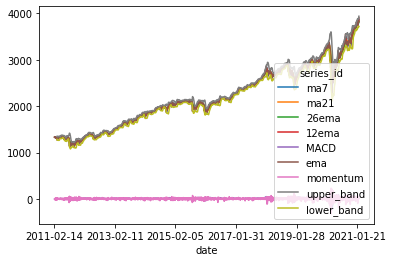

In [17]:
tech.plot()

In [18]:
tech = (tech - tech.mean()) / tech.std()

## Fourier transforms 

In [19]:
import numpy as np
import pylab as pl
from numpy import fft

In [20]:
def fourierExtrapolation(x, n_predict, n_harm):
    n = x.size            
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [21]:
len(merged)

2516

In [22]:
ft = merged.copy()

In [23]:
for harm in [3,5,10,100]:
    pred = []
    for i in range(2,len(merged)):
        pred.append(fourierExtrapolation(merged.values[max(0,i - 1000) :i,0],1, harm)[-1])
    ft["ft" + str(harm)] = [np.NaN,np.NaN] + pred

<AxesSubplot:xlabel='date'>

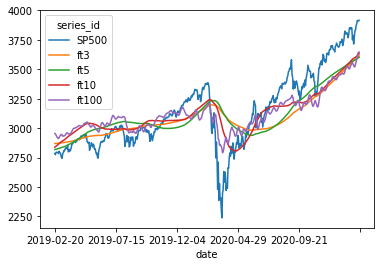

In [24]:
ft.tail(500).plot()

In [25]:
ft.to_csv("datasets/FT.csv")

In [26]:
ft = (ft - ft.mean())/ ft.std()

## Date

In [27]:
doy = pd.to_datetime(df.index.values).dayofyear

In [28]:
df.index.values

array(['2000-01-03', '2000-01-04', '2000-01-05', ..., '2021-02-10',
       '2021-02-11', '2021-02-12'], dtype=object)

In [29]:
df['SIN_DATE'] = np.sin(2*np.pi*doy/365)
df['COS_DATE'] = np.cos(2*np.pi*doy/365)

## Merge Everything

In [30]:
df = df.merge(ft.drop(columns = "SP500"), how = "left", left_index=True, right_index=True)
df = df.merge(tech, how = "left", left_index=True, right_index=True)
df = df.merge(merged, how = "left", left_index=True, right_index=True)
df = df.merge(diff, how = "left", suffixes = [None, "_DIFF"], left_index=True, right_index=True)

In [31]:
df = df.rename(columns={"SP500_y": "SP500_UNNORM", "SP500_x":"SP500_NORM"})[:-1]

In [32]:
df.tail()

series_id,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,SFTPAGRM158SFRBSF_DIFF,SOFR_DIFF,SOFRVOL_DIFF,T10YIE_DIFF,TEDRATE_DIFF,TLAACBW027NBOG_DIFF,TLBACBW027NBOG_DIFF,TSIFRGHT_DIFF,UNRATE_DIFF,WLEMUINDXD_DIFF
date,,,,,,,,,,,,,,,,,,,,,
2021-02-05,-0.302713,-0.579975,-0.590471,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,0.02659,-0.030828,-0.401441,0.096898,-0.025033,0.0101,0.009509,0.060515,5.428199,-0.442386
2021-02-08,-0.348868,-0.579975,-0.644321,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,0.02659,0.000000,-0.093192,0.024225,-0.025033,0.0101,0.009509,0.060515,5.428199,-0.442386
2021-02-09,-0.348868,-0.579975,-0.630858,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,0.02659,0.030828,-0.136203,0.000000,-0.025033,0.0101,0.009509,0.060515,5.428199,-0.442386
2021-02-10,-0.325791,-0.579975,-0.617396,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,0.02659,0.010276,-0.121866,-0.024225,-0.025033,0.0101,0.009509,0.060515,5.428199,-0.442386
2021-02-11,-0.325791,-0.579975,-0.617396,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,0.02659,0.000000,0.050180,-0.024225,-0.025033,0.0101,0.009509,0.060515,5.428199,-0.442386


In [33]:
df.isna().mean()

series_id
AAA10Y                 0.000000
ASEANTOT               0.163169
BAA10Y                 0.000000
BUSAPPWNSAUS           0.251065
BUSAPPWNSAUSYY         0.300458
                         ...   
TLAACBW027NBOG_DIFF    0.001262
TLBACBW027NBOG_DIFF    0.001262
TSIFRGHT_DIFF          0.006786
UNRATE_DIFF            0.006786
WLEMUINDXD_DIFF        0.000316
Length: 155, dtype: float64

In [34]:
df.to_csv("datasets/all_features.csv")

In [35]:
df["SP500_UNNORM"].dropna()

date
2011-02-14    1332.32
2011-02-15    1328.01
2011-02-16    1336.32
2011-02-17    1340.43
2011-02-18    1343.01
               ...   
2021-02-05    3886.83
2021-02-08    3915.59
2021-02-09    3911.23
2021-02-10    3909.88
2021-02-11    3916.38
Name: SP500_UNNORM, Length: 2516, dtype: float64

In [36]:
merged.std()

series_id
SP500    651.490181
dtype: float64

In [90]:
p = df[["ft10"]].dropna().merge(df[['SP500_NORM']].dropna(), how="left", left_index = True,  right_index = True)

In [99]:
np.mean((p.ft10 - p.SP500_NORM)**2)

0.02801478453475729

In [100]:
np.mean((p.SP500_NORM.shift(1) - p.SP500_NORM)**2)

0.0015871052233312382